In [1]:
import pickle
import glob
import json
import time
import pandas as pd
import seaborn as sns
from langchain.vectorstores import FAISS
from langchain.embeddings.openai import OpenAIEmbeddings
from langchain.chat_models import ChatOpenAI
from langchain.chains import RetrievalQA
from matplotlib import rcParams
import matplotlib.pyplot as plt

import os
os.environ['OPENAI_API_KEY'] = ''

# Open the manuscript dictionaries to get DOIs

In [2]:
with open('data_input/scipdf.pkl', 'rb') as handle:
    pdf_dict = pickle.load(handle)

pdf_doi_dict = {}
for pdf_name in pdf_dict.keys():
    pdf_doi_dict[pdf_name.replace(".pdf", "")] = pdf_dict[pdf_name]["doi"]

# Extract all trait information from the 36 manuscripts

In [ ]:
for model in ["gpt-3.5-turbo", "gpt-4"]:
    trait_results = pd.DataFrame()
    json_dict = {}
    fail_list = []
    for key in pdf_dict.keys():
        embeddings = OpenAIEmbeddings()
        key = key.replace(".pdf", "")
        if key not in ["agronomy-12-02839"]:
            continue

        time.sleep(2)

        db = FAISS.load_local("data_faiss/faiss_chunked/faiss_db_1000/{}".format(key), embeddings, allow_dangerous_deserialization=True)
        retriever = db.as_retriever(search_type="similarity_score_threshold",
                                    search_kwargs={"score_threshold": 0.5, "k": 25})

        query = """Find and extract all the traits that were measured in the provided genetic mapping manuscript. \
                Traits are defined as measured phenotypes, conditions and environments. \
                If a trait was measured using different methods, include each condition as a separate trait. \
                Only include trait abbreviation if it was used in the text, otherwise return 'None'. \
                Do not include traits that were referenced but not measured in this study. 

                Important - Respond in JSON format only, following the schema below:
                    ```json
                    {
                    "trait_name": string  // full name of the measured trait, non-abbreviated,
                    "trait_abv": string  // abbreviated trait name, only if provided, otherwise 'None'
                    "trait_description": string // A description of the methods and conditions used to measure the trait
                    }```
                """
        
        # Uncommend the LLM model you want to use for the RAG chain
        llm = ChatOpenAI(model_name=model)
        qa = RetrievalQA.from_chain_type(llm=llm, chain_type="stuff", retriever=retriever, temperature=0.7)
        marker_response = qa(query)

        json_dict[key] = marker_response['result']

        try:
            response_string = marker_response['result']
            response_string = response_string.split("```")[1] if "```" in response_string else response_string
            response_string = response_string.replace("```", "")
            response_string = response_string.replace("json\n", "")
            response_string = response_string.replace("}\n{", "},\n{")
            response_string = response_string.replace("\n}\n}\n", "\n}\n")
            response_string = response_string.replace("}\n", "}")

            if "[" not in response_string:
                response_string = "[" + response_string
            if "]" not in response_string:
                response_string = response_string + "]"

            # Parse the JSON format and turn it into a pandas dataframe
            response_json = json.loads(response_string)
            tmp_df = pd.DataFrame(response_json)

            # Add the PDF and DOI IDs so it is easier to keep track of
            tmp_df["pdf"] = key
            tmp_df["doi"] = pdf_doi_dict[key]
            tmp_df["k"] = 25
            tmp_df["size"] = 1000
            trait_results = pd.concat([trait_results, tmp_df])
            print("success,"+key)
        except:
            print("fail,"+key)
            fail_list.append([key, marker_response['result']])
    trait_results.to_csv(f"data_output/traits/36.traits.{model}.tsv", sep="\t", index=None)

# Make Fog. 3B using all 36 papers

         % correct
Model             
GPT-3.5  70.393222
GPT-4    80.137108


/Users/eporetsky/mambaforge/envs/chatmta/lib/python3.10/site-packages/seaborn/categorical.py:3370: UserWarning: 16.7% of the points cannot be placed; you may want to decrease the size of the markers or use stripplot.
  warnings.warn(msg, UserWarning)


<Axes: xlabel='Model', ylabel='% correct'>

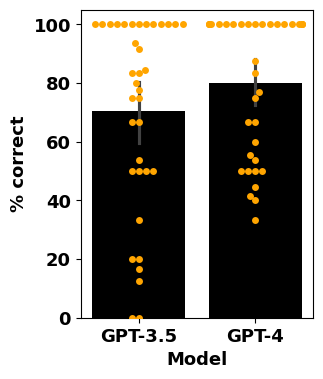

In [4]:
true_traits = pd.read_csv("data_figures/36.traits.curated.tsv", sep="\t", encoding = 'ISO-8859-1')
true_traits = true_traits.groupby("doi").count().reset_index()[["doi", "trait"]]

pred_traits = pd.read_csv("data_figures/36.traits.tsv", sep="\t", encoding = 'ISO-8859-1')
results = pred_traits.groupby(["Model","doi"]).sum().reset_index()[["Model", "doi", "correct"]]
results = results.merge(true_traits, on="doi", how="outer")

results = results.fillna(0) # out join with missing results returns NaN
results['% correct'] = results["correct"] / results["trait"] * 100

print(results[["Model", "% correct"]].groupby("Model").mean())
plt.rcParams.update({'font.weight': 'bold', 'font.size': 13, 
                     'axes.labelweight': 'bold', 'axes.titleweight': 'bold'})
fig, ax = plt.subplots(figsize=(3, 4))

sns.barplot(data=results, x="Model", y= "% correct", color="black")
sns.swarmplot(data=results, x="Model", y= "% correct", color="orange")

# Make Fig. 3G

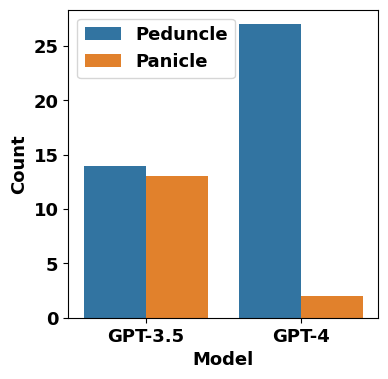

In [5]:
#rcParams['figure.figsize'] = 5, 5
plt.rcParams.update({'font.weight': 'bold', 'font.size': 13, 
                     'axes.labelweight': 'bold', 'axes.titleweight': 'bold'})
fig, ax = plt.subplots(figsize=(4, 4))


ped_df = [["GPT-3.5", "GPT-3.5", "GPT-4", "GPT-4"], 
          ["Peduncle", "Panicle", "Peduncle", "Panicle"],
          [14, 13, 27, 2]]
ped_df = pd.DataFrame(ped_df).T
ped_df.columns = ["Model", "Trait", "Count"]
sns.barplot(ped_df, x="Model", y="Count", hue="Trait")
plt.legend(loc='upper left')

# Analyze a single paper with different chunk sizes and K

In [ ]:
# Selected manuscript to analyze
key = "s00122-014-2435-3.pdf"

for model in ["gpt-3.5-turbo", "gpt-4"]:
    trait_results = pd.DataFrame()
    fail_list = []

    for size in [250,500,750,1000]:
        for k in [5,10,15,20,25]:
            for rep in [1,2,3]:
                time.sleep(2)
                embeddings = OpenAIEmbeddings()
                key = key.replace(".pdf", "")
                db = FAISS.load_local("data_faiss/faiss_chunked/faiss_db_{}/{}".format(size, key), embeddings,
                                    allow_dangerous_deserialization=True)
                
                retriever = db.as_retriever(search_type="similarity_score_threshold",
                                            search_kwargs={"score_threshold": 0.5, "k": k})
                
                query = """Find and extract all the traits that were measured in the provided genetic mapping manuscript. \
                        Traits are defined as measured phenotypes, conditions and environments. \
                        If a trait was measured using different methods, include each condition as a separate trait. \
                        Only include trait abbreviation if it was used in the text, otherwise return 'None'. \
                        Do not include traits that were referenced but not measured in this study. 

                        Important - Respond in JSON format only, following the schema below:
                            ```json
                            {
                            "trait_name": string  // full name of the measured trait, non-abbreviated,
                            "trait_abv": string  // abbreviated trait name, only if provided, otherwise 'None'
                            "trait_description": string // A description of the methods and conditions used to measure the trait
                            }```
                        """
                # Uncommend the LLM model you want to use for the RAG chain
                llm = ChatOpenAI(model_name=model) 
                qa = RetrievalQA.from_chain_type(llm=llm, chain_type="stuff", retriever=retriever, temperature=0.7)
                marker_response = qa(query)
                
                # Correct the returned JSON format based on observed errors
                json_dict[key] = marker_response['result']
                try:
                    response_string = marker_response['result']
                    response_string = response_string.split("```")[1] if "```" in response_string else response_string
                    response_string = response_string.replace("```", "")
                    response_string = response_string.replace("json\n", "")
                    response_string = response_string.replace("}\n{", "},\n{")
                    response_string = response_string.replace("\n}\n}\n", "\n}\n")
                    response_string = response_string.replace("}\n", "}")
                    
                    if "[" not in response_string:
                        response_string = "[" + response_string
                    if "]" not in response_string:
                        response_string = response_string + "]"
                    
                    # Parse the JSON format and turn it into a pandas dataframe
                    tmp_df = pd.DataFrame(response_json)
                    
                    tmp_df["pdf"] = key
                    tmp_df["doi"] = pdf_doi_dict[key]
                    tmp_df["k"] = k
                    tmp_df["rep"] = rep
                    tmp_df["size"] = size
                    trait_results = pd.concat([trait_results, tmp_df])
                    print("success,"+key)
                except:
                    print("fail,"+key)
                    fail_list.append([key, size, k, rep, marker_response['result']])
    trait_results.to_csv(f"data_output/traits/p2.traits.{model}.tsv", sep="\t", index=None)

In [ ]:
# The number of traits in the #2 manuscript
true_traits = 16

plt.rcParams.update({'font.weight': 'bold', 'font.size': 13, 
                     'axes.labelweight': 'bold', 'axes.titleweight': 'bold'})
fig, ax = plt.subplots(figsize=(3.5, 3))

trait_results = pd.read_csv("data_figures/p2.traits.gpt-3.5-turbo.tsv" ,sep="\t")
trait_results = trait_results[trait_results["correct"]==1]
trait_results = trait_results[["k", "rep", "size", "correct"]].groupby(["k", "rep", "size"]).sum().reset_index()
trait_results["correct"] = trait_results["correct"] / true_traits * 100
trait_results.columns = ["K Size", "rep", "Chunk Size", "% correct"]
ax = sns.barplot(data=trait_results, x="Chunk Size", y="% correct", hue="K Size", errorbar="sd")
ax.get_legend().remove()
ax.set_title("GPT-3.5")
plt.ylim(0, 110)

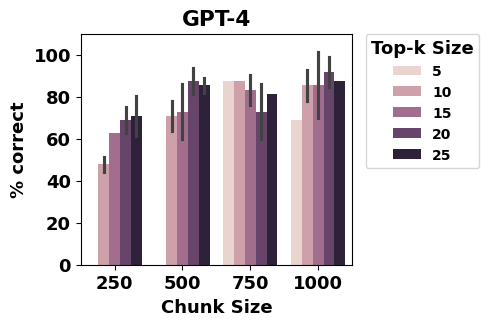

In [ ]:
true_traits = 16

plt.rcParams.update({'font.weight': 'bold', 'font.size': 13, 
                     'axes.labelweight': 'bold', 'axes.titleweight': 'bold'})
fig, ax = plt.subplots(figsize=(3.5, 3))

trait_results = pd.read_csv("data_figures/p2.traits.gpt-4.tsv" ,sep="\t")

trait_results = trait_results[trait_results["correct"]==1]
trait_results = trait_results[["k", "rep", "size", "correct"]].groupby(["k", "rep", "size"]).sum().reset_index()
trait_results["correct"] = trait_results["correct"] / true_traits * 100
trait_results.columns = ["Top-k Size", "rep", "Chunk Size", "% correct"]
ax = sns.barplot(data=trait_results, x="Chunk Size", y="% correct", hue="Top-k Size", errorbar="sd")
ax.set_title("GPT-4")
plt.ylim(0, 110)

plt.legend(title="Top-k Size", prop={'size': 10}, # loc='upper left', 
           bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)